In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from PIL import Image

# Set paths
train_dir = '/content/drive/MyDrive/ped2/ped2/training'
test_dir = '/content/drive/MyDrive/ped2/ped2/testing'

# Parameters
image_size = (126, 126)
batch_size = 256
num_classes = 2  # Normal (0) and Anomaly (1)

In [ ]:
import os

# Function to list, count folders, and calculate file size
def list_and_count_folders_with_files(directory):
    folder_info = []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):  # Check if it's a folder
            file_count = 0
            total_size = 0
            for root, _, files in os.walk(folder_path):
                file_count += len(files)
                total_size += sum(os.path.getsize(os.path.join(root, f)) for f in files)
            folder_info.append((folder_name, file_count, total_size))

    # Print folder information
    print(f"Folders in {directory}:")
    for name, count, size in folder_info:
        print(f"  {name}: {count} files, {size / 1024:.2f} KB")

    return len(folder_info), folder_info

# Print train and test dataset folders with counts and file sizes
train_count, train_info = list_and_count_folders_with_files(train_dir)
print(f"Total Train Folders: {train_count}\n")

test_count, test_info = list_and_count_folders_with_files(test_dir)
print(f"Total Test Folders: {test_count}")


Folders in /content/drive/MyDrive/ped2/ped2/training:
  frames: 2550 files, 55760.94 KB
Total Train Folders: 1

Folders in /content/drive/MyDrive/ped2/ped2/testing:
  frames: 1901 files, 43529.71 KB
Total Test Folders: 1


In [ ]:
# Preprocessing function
def preprocess_images(directory, image_size):
    images, labels = [], []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        label = 1 if 'anomaly' in folder_name.lower() else 0  # Adjust based on your folder naming convention
        for file_name in os.listdir(folder_path):
            if not file_name.endswith(('.tif', '.png', '.jpg', '.jpeg')):  # Skip non-image files
                continue
            file_path = os.path.join(folder_path, file_name)
            try:
                img = Image.open(file_path).resize(image_size).convert('RGB')
                images.append(np.array(img))
                labels.append(label)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
    return np.array(images), np.array(labels)


# Load and preprocess data
x_train, y_train = preprocess_images(train_dir, image_size)
x_test, y_test = preprocess_images(test_dir, image_size)

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

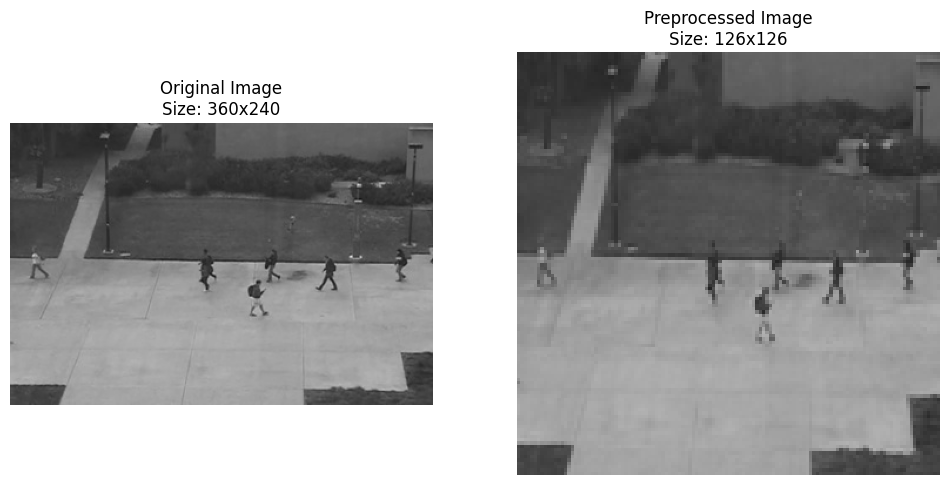

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Display a sample image before and after preprocessing with size annotations
def display_image_samples_with_size(directory, image_size):
    # Get a list of folder names (train or test folder)
    folder_name = os.listdir(directory)[0]  # Just use the first folder for demonstration
    folder_path = os.path.join(directory, folder_name)

    # Loop through the folder and find an image file (ignoring directories)
    for sample_image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, sample_image_file)

        # Only process if it's an image file (checking extension)
        if os.path.isfile(image_path) and sample_image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                # Load the image using PIL
                original_image = Image.open(image_path)

                # Preprocess the image (resize and normalize)
                preprocessed_image = original_image.resize(image_size).convert('RGB')
                preprocessed_image = np.array(preprocessed_image) / 255.0

                # Get the size of original and preprocessed images
                original_size = original_image.size  # (width, height)
                preprocessed_size = preprocessed_image.shape  # (height, width, channels)

                # Create the plot with original and preprocessed images
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))

                # Original Image
                axes[0].imshow(original_image)
                axes[0].set_title(f"Original Image\nSize: {original_size[0]}x{original_size[1]}")
                axes[0].axis('off')  # Hide axes

                # Preprocessed Image
                axes[1].imshow(preprocessed_image)
                axes[1].set_title(f"Preprocessed Image\nSize: {preprocessed_size[1]}x{preprocessed_size[0]}")
                axes[1].axis('off')  # Hide axes

                # Show the plot
                plt.show()
                break  # Exit after processing the first image
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                continue

# Display sample images before and after preprocessing with size info from the training directory
display_image_samples_with_size('/content/drive/MyDrive/ped2/ped2/training/frames', (126, 126))


In [ ]:
# Parameters
image_size = (126, 126)
batch_size = 256
num_classes = 2  # Normal (0) and Anomaly (1)

# Load ResNet50 without the top layer (classification layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(126, 126, 3))

# Freeze the layers in the base model to prevent them from being updated during training
base_model.trainable = False

# Build the model by adding custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing with ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=image_size,
                                                    batch_size=batch_size, class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(test_dir, target_size=image_size,
                                                        batch_size=batch_size, class_mode='sparse')

# Train the model
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=2,
                    validation_data=validation_generator, validation_steps=len(validation_generator))

# Evaluate the model
test_generator = test_datagen.flow_from_directory(test_dir, target_size=image_size,
                                                  batch_size=batch_size, class_mode='sparse')

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

# Predict and evaluate the model on the test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_generator.classes

# Confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

cr = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'])
print("Classification Report:\n", cr)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, ['Normal', 'Anomaly'])
plt.yticks(tick_marks, ['Normal', 'Anomaly'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Found 2550 images belonging to 1 classes.
Found 2010 images belonging to 1 classes.
Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 1037s 108s/step - accuracy: 1.0000 - loss: 0.1635 - val_accuracy: 1.0000 - val_loss: 1.9882e-05
Epoch 2/2


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Found 2010 images belonging to 1 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 231s 29s/step - accuracy: 1.0000 - loss: 1.9842e-05
Test accuracy: 1.0
8/8 ━━━━━━━━━━━━━━━━━━━━ 246s 29s/step
Confusion Matrix:
 [[2010]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

8/8 ━━━━━━━━━━━━━━━━━━━━ 235s 29s/step
Confusion Matrix:
 [[2010]]
Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2010
     Anomaly       0.00      0.00      0.00         0

    accuracy                           1.00      2010
   macro avg       0.50      0.50      0.50      2010
weighted avg       1.00      1.00      1.00      2010



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-s

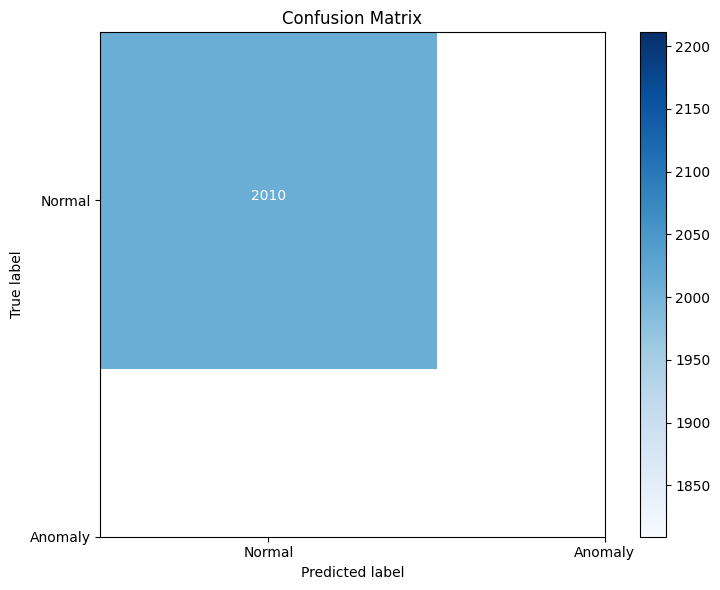

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Assuming the predictions and true labels are already available as y_true and y_pred
# Get true labels
y_true = test_generator.classes

# Get predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# If there are fewer classes, adjust the labels argument to match the available classes
try:
    cr = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'], labels=[0, 1])
except ValueError as e:
    print(f"Error in classification report: {e}")
    cr = "Classification report could not be generated due to missing classes."

# Print confusion matrix and classification report
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

# Plot the confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Anomaly'])
plt.yticks(tick_marks, ['Normal', 'Anomaly'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Annotate the confusion matrix with values
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
